# 3. Regression
In this notebook we will finally run our regression models. For that purpose, we are importing the necessary libraries and functions from our ```modules``` folder. We are also importing our extracted dataframe

In [1]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from scipy import stats
from functools import reduce

# Statsmodels
import statsmodels.api as sm
import pmdarima as pmd
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning models
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    r2_score,
    precision_score

)

from xgboost import XGBRegressor



In [2]:
# We import our own functions
import sys
sys.path.append('../../..')  # Move two levels up to the project root
from modules.functions import *

In [3]:
df = pd.read_csv('../../../input/df_raw_test.csv', parse_dates=['Fecha'], index_col='Fecha')
df.tail()

,CPI,Monetary Policy Rate,Exchange rate,Circulating Currency Seasonally Adjusted (mill S/),Net International Reserves (mill $),Real Minimum Wage (Index),Wheat (US$ per ton),Corn (US$ per ton),Soybean oil (US$ per ton),Crude oil (US$ per barrel)
Fecha,,,,,,,,,,
2023-08-01,0.182324,7.75,3.697768,11.194037,11.182374,5.646268,5.714305,5.288844,7.354495,4.399204
2023-09-01,0.133933,7.50,3.730995,11.196305,11.173721,5.646104,5.677783,5.178940,7.283402,4.490772
2023-10-01,0.085365,7.25,3.845759,11.202967,11.172515,5.649334,5.548594,5.191875,7.138916,4.448655
2023-11-01,0.036736,7.00,3.760795,11.200187,11.180961,5.650966,5.567082,5.146240,7.076030,4.351357
2023-12-01,-0.011845,6.75,3.733942,11.186627,11.170900,5.646966,5.599153,5.145342,7.046320,4.276196


In [4]:
df_lags = pd.read_csv('../../../input/df_lags_test.csv', parse_dates=['Fecha'], index_col='Fecha')
df_lags.tail()

,CPI,Monetary Policy Rate_lag_1,Monetary Policy Rate_lag_2,Monetary Policy Rate_lag_3,Monetary Policy Rate_lag_4,Exchange rate_lag_1,Exchange rate_lag_2,Exchange rate_lag_3,Exchange rate_lag_4,Circulating Currency Seasonally Adjusted (mill S/)_lag_1,...,Corn (US$ per ton)_lag_3,Corn (US$ per ton)_lag_4,Soybean oil (US$ per ton)_lag_1,Soybean oil (US$ per ton)_lag_2,Soybean oil (US$ per ton)_lag_3,Soybean oil (US$ per ton)_lag_4,Crude oil (US$ per barrel)_lag_1,Crude oil (US$ per barrel)_lag_2,Crude oil (US$ per barrel)_lag_3,Crude oil (US$ per barrel)_lag_4
Fecha,,,,,,,,,,,,,,,,,,,,,
2023-08-01,0.182324,7.75,7.75,7.75,7.75,3.601255,3.650419,3.688668,3.765450,11.196625,...,5.461808,5.531248,7.342273,7.158705,7.063081,7.124298,4.327658,4.253043,4.271259,4.375870
2023-09-01,0.133933,7.75,7.75,7.75,7.75,3.697768,3.601255,3.650419,3.688668,11.194037,...,5.487035,5.461808,7.354495,7.342273,7.158705,7.063081,4.399204,4.327658,4.253043,4.271259
2023-10-01,0.085365,7.50,7.75,7.75,7.75,3.730995,3.697768,3.601255,3.650419,11.196305,...,5.368204,5.487035,7.283402,7.354495,7.342273,7.158705,4.490772,4.399204,4.327658,4.253043
2023-11-01,0.036736,7.25,7.50,7.75,7.75,3.845759,3.730995,3.697768,3.601255,11.202967,...,5.288844,5.368204,7.138916,7.283402,7.354495,7.342273,4.448655,4.490772,4.399204,4.327658
2023-12-01,-0.011845,7.00,7.25,7.50,7.75,3.760795,3.845759,3.730995,3.697768,11.200187,...,5.178940,5.288844,7.076030,7.138916,7.283402,7.354495,4.351357,4.448655,4.490772,4.399204


In [5]:
df = df[:'2019-12-01']
df_lags = df_lags[:'2019-12-01'] 

## 3.1 Benchmark models

In the first section, we first run our benchmark econometric models: ```Random Walk (RW)```,  ```Autoregressive Integrated Moving Average (ARIMA)``` and ```Vector Autoregression (VAR)``` processes

### 3.1.1 Random Walk (RW)

In [6]:
forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# We define our target variable
target = 'CPI'

# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2019-01-01']
test_set  = df_CPI[df_CPI.index >= '2019-01-01']

predictions = {}

for h in forecast_horizons:
    # We get the values h horizons before
    predicted_value = train_set.iloc[-1, 0] 

    # We save it for horizon h
    predictions[h] = predicted_value

predicted = pd.DataFrame([predictions]).transpose().reset_index()

predicted.columns = ['Horizon', 'Prediction']

predicted = predicted.set_index(test_set.index)

predicted

,Horizon,Prediction
Fecha,,
2019-01-01,1,0.19049
2019-02-01,2,0.19049
2019-03-01,3,0.19049
2019-04-01,4,0.19049
2019-05-01,5,0.19049
2019-06-01,6,0.19049
2019-07-01,7,0.19049
2019-08-01,8,0.19049
2019-09-01,9,0.19049


In [7]:
# We create our results dataframe, concatenating the predicted and the actual values
results_rw = pd.concat([predicted, test_set[target]], axis=1)
results_rw.rename(columns={'Horizon': 'Horizon', 'Prediction': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results_rw

,Horizon,Predicted,Actual
Fecha,,,
2019-01-01,1,0.19049,0.183963
2019-02-01,2,0.19049,0.175141
2019-03-01,3,0.19049,0.166761
2019-04-01,4,0.19049,0.160654
2019-05-01,5,0.19049,0.157488
2019-06-01,6,0.19049,0.156027
2019-07-01,7,0.19049,0.155721
2019-08-01,8,0.19049,0.156584
2019-09-01,9,0.19049,0.156844


In [8]:
# We get our metrics using our function
RMSE_rw, MAPE_rw = get_metrics(results_rw, 'RW')
metrics_rw = pd.concat([RMSE_rw, MAPE_rw], axis = 1)
metrics_rw

,RMSE_RW,MAPE_RW
1,0.006527,0.035478
2,0.011793,0.061556
3,0.016746,0.088469
4,0.020805,0.112780
5,0.023751,0.132134
6,0.025846,0.146924
7,0.027300,0.157831
8,0.028210,0.165169
9,0.028865,0.170652
10,0.029558,0.176242


### 3.1.2 Autoregressive Integrated Moving Average (ARIMA)

In [9]:
# # We only use CPI as Random Walk is an univariate process
# df_CPI = pd.DataFrame(df_lags.CPI)

# # We create our train and test set
# train_set = df_CPI[df_CPI.index < '2022-01-01']
# test_set  = df_CPI[df_CPI.index >= '2022-01-01']

In [10]:
# # We find the best SARIMA model
# autoarima = pmd.auto_arima(
#         y = train_set,
#         start_p=1,
#         start_q=0,
#         seasonal=True,
#         max_p=12,
#         max_d=1,
#         max_q=6,
#         max_P=12,
#         max_D=1,
#         max_Q=6,
#         m=4,
#         n_jobs=-1,
#         suppress_warnings=True,
#         )

# # We indicate the seasonal order for monthly data
# seasonal_order = (1, 1, 1, 12)

# # We create our ARIMA model
# model = SARIMAX(train_set,
#                 order=autoarima.order,
#                 seasonal_order=autoarima.seasonal_order,
#                 enforce_stationarity = False,
#                 enforce_invertibility = False)
        
# # We fit the model
# model_fit = model.fit()

# # We forecast for the next 12 horizons
# forecast_values = model_fit.get_forecast(steps=12)
# predicted = pd.DataFrame(forecast_values.predicted_mean, index = test_set.index)

# # We create our results dataframe, concatenating the predicted and the actual values
# results = pd.concat([predicted, test_set[target]], axis=1)
# results.rename(columns={'predicted_mean': 'Predicted', 'CPI': 'Actual'}, inplace=True)
# results

In [11]:
# We get our metrics using our function
# RMSE_arima, MAPE_arima = get_metrics(results, 'ARIMA')
# metrics_arima= pd.concat([RMSE_arima, MAPE_arima], axis = 1)
# metrics_arima

### 3.1.3 Vector autoregression (VAR)

In [12]:
# We define our target variable, as well as our train and test set
target = 'CPI'
train_set = df[df.index < '2019-01-01']
test_set  = df[df.index >= '2019-01-01']

In [13]:
# We model our VAR including up to two lags
model_var = VAR(df)
model_fit = model_var.fit(4)

In [14]:
# Summary of the model
# model_fit.summary()

In [15]:
# We forecast for the next 12 months
preds = model_fit.forecast(df.values[-4:], 12)
preds = pd.DataFrame(preds, index = test_set[target].index)[0]

# We create our results dataframe, concatenating the predicted and the actual values
results_var = pd.concat([preds, test_set[target]],axis=1)
results_var.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_var

,Predicted,Actual
Fecha,,
2019-01-01,0.142335,0.183963
2019-02-01,0.140215,0.175141
2019-03-01,0.140361,0.166761
2019-04-01,0.142004,0.160654
2019-05-01,0.143777,0.157488
2019-06-01,0.144410,0.156027
2019-07-01,0.143244,0.155721
2019-08-01,0.140337,0.156584
2019-09-01,0.136286,0.156844


In [16]:
# We get our metrics using our function
RMSE_var, MAPE_var = get_metrics(results_var, 'VAR')
metrics_var= pd.concat([RMSE_var, MAPE_var], axis = 1)
metrics_var

,RMSE_VAR,MAPE_VAR
1,0.041628,0.226283
2,0.038424,0.212851
3,0.034879,0.194671
4,0.031613,0.175024
5,0.028933,0.157432
6,0.026834,0.143602
7,0.025287,0.134534
8,0.024342,0.130688
9,0.023951,0.130731
10,0.023897,0.132727


<Axes: >

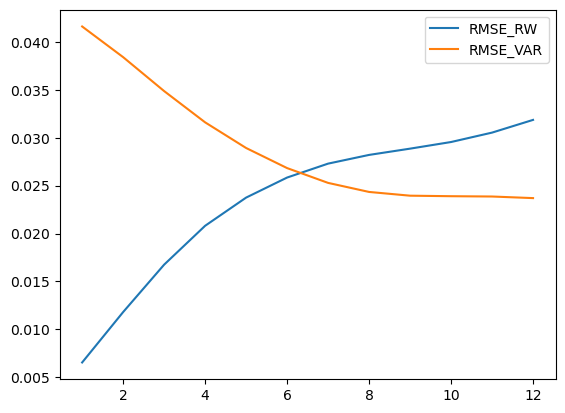

In [17]:
rmse_econometrics = pd.concat([RMSE_rw, RMSE_var], axis=1)

rmse_econometrics.plot()

## 3.2 Machine learning models

In the second section, we run our machine learning models: ```Ridge Regression (Ridge)```,  ```Least Absolute Shrinkage and Selection Operator (LASSO)``` and ```Random Forest (RF)``` models

### 3.2.1 Ridge Regression (Ridge)

In [18]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We define the model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.linear_model as skl
scaler = StandardScaler()

# Define model
model = Pipeline([
    ('scaler', scaler),
    ('regressor', ElasticNet(random_state=2024, l1_ratio=1))  
])

# Define grid search
grid_params = {
    'regressor__alpha': np.linspace(0.01, 1, 1000) 
}

# We implement our gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')

grid_search.fit( X_train, y_train )

pd.DataFrame( grid_search.cv_results_ )

# And select out best model
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

ridge_model = best_model
ridge_params = best_params

In [19]:
pred_vars = X_train.columns.to_list()
coefficients = best_model.named_steps['regressor'].coef_
vars_df_ridge      = pd.DataFrame( {'Var': X_train.columns, 'Coefficient': coefficients } )
vars_df_ridge      = vars_df_ridge.reindex( vars_df_ridge[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_ridge.to_excel( f'../../../output/3_Regression/h19_test/h19coef_ridge.xlsx' )

In [20]:
# We use the best model to predict
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)
y_pred

Fecha
2019-01-01    0.237698
2019-02-01    0.237698
2019-03-01    0.237698
2019-04-01    0.237698
2019-05-01    0.237698
2019-06-01    0.237698
2019-07-01    0.237698
2019-08-01    0.237698
2019-09-01    0.237698
2019-10-01    0.237698
2019-11-01    0.237698
2019-12-01    0.237698
dtype: float64

In [21]:
# And concatenate the results
results_ridge = pd.concat([y_pred, y_test],axis=1)
results_ridge.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_ridge

,Predicted,Actual
Fecha,,
2019-01-01,0.237698,0.183963
2019-02-01,0.237698,0.175141
2019-03-01,0.237698,0.166761
2019-04-01,0.237698,0.160654
2019-05-01,0.237698,0.157488
2019-06-01,0.237698,0.156027
2019-07-01,0.237698,0.155721
2019-08-01,0.237698,0.156584
2019-09-01,0.237698,0.156844


In [22]:
RMSE_ridge, MAPE_ridge = get_metrics(results_ridge, 'Ridge')

<Axes: >

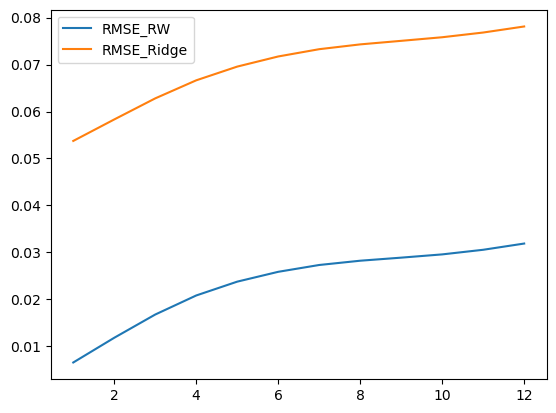

In [23]:
pd.concat([RMSE_rw, RMSE_ridge], axis=1).plot()

### 3.2.2 Lasso Regression (Lasso)

In [24]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# We define the model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.linear_model as skl
scaler = StandardScaler()

# Define model
model = Pipeline([
    ('scaler', scaler),
    ('regressor', ElasticNet(random_state=2024, l1_ratio=1))  
])

# Define grid search
grid_params = {
    'regressor__alpha': np.linspace(0.001, 1, 1000) 
}


# We implement the gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')
grid_search.fit( X_train, y_train )
pd.DataFrame( grid_search.cv_results_ )

best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

lasso_model = best_model
lasso_params = best_params

In [25]:
pred_vars = X_train.columns.to_list()
coefficients = best_model.named_steps['regressor'].coef_
vars_df_lasso      = pd.DataFrame( {'Var': X_train.columns, 'Coefficient': coefficients } )
vars_df_lasso      = vars_df_lasso.reindex( vars_df_lasso[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_lasso.to_excel( f'../../../output/3_Regression/h19_test/h19coef_lasso.xlsx' )

In [26]:
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [27]:
results_lasso = pd.concat([y_pred, y_test],axis=1)
results_lasso.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_lasso

,Predicted,Actual
Fecha,,
2019-01-01,0.237698,0.183963
2019-02-01,0.237698,0.175141
2019-03-01,0.237698,0.166761
2019-04-01,0.237698,0.160654
2019-05-01,0.237698,0.157488
2019-06-01,0.237698,0.156027
2019-07-01,0.237698,0.155721
2019-08-01,0.237698,0.156584
2019-09-01,0.237698,0.156844


In [28]:
RMSE_lasso, MAPE_lasso = get_metrics(results_lasso, 'Lasso')

<Axes: >

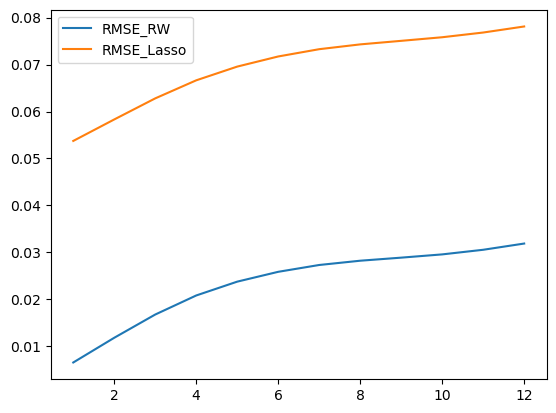

In [29]:
pd.concat([RMSE_rw, RMSE_lasso], axis=1).plot()

### 3.2.3 Random Forest Regression (Random Forest)

In [30]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor( random_state = 2024, n_jobs = -1 )
model = random_forest

# param_grid = {
#     'n_estimators': [100, 200, 500, 1000],  # Incrementado para explorar un mayor número de árboles
#     'max_features': ['auto', 'sqrt', 'log2'],  # Agregado 'log2' para considerar menos features por split
#     'max_depth': [10, 20, 30, None],  # Agregado None para permitir árboles completos
#     'min_samples_split': [2, 5, 10],  # Agregado 10 para ver el efecto de más restricciones en el split
#     'min_samples_leaf': [1, 2, 4]  # Agregado 4 para incrementar la generalización
# }

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'Log2'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


grid_search = GridSearchCV( model, param_grid, cv = tscv, scoring = 'neg_mean_squared_error')
grid_search.fit( X_train, y_train )

pd.DataFrame( grid_search.cv_results_ )

# And select out best model
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [31]:
best_params

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [32]:
pred_vars = X_train.columns.to_list()
feature_importances = best_model.feature_importances_
vars_df_rf             = pd.DataFrame( {'Var': pred_vars, 'Importance Score': feature_importances } )
vars_df_rf             = vars_df_rf.reindex(vars_df_rf[ 'Importance Score' ].abs().sort_values( ascending = False ).index )
vars_df_rf.to_excel( f'../../../output/3_Regression/h19_test/h19coef_rf.xlsx' )

In [33]:
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [34]:
results_rf = pd.concat([y_pred, y_test],axis=1)
results_rf.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_rf

,Predicted,Actual
Fecha,,
2019-01-01,0.197072,0.183963
2019-02-01,0.205373,0.175141
2019-03-01,0.199344,0.166761
2019-04-01,0.192433,0.160654
2019-05-01,0.185489,0.157488
2019-06-01,0.184095,0.156027
2019-07-01,0.189067,0.155721
2019-08-01,0.190458,0.156584
2019-09-01,0.193395,0.156844


In [35]:
RMSE_rf, MAPE_rf = get_metrics(results_rf, 'RF')

<Axes: >

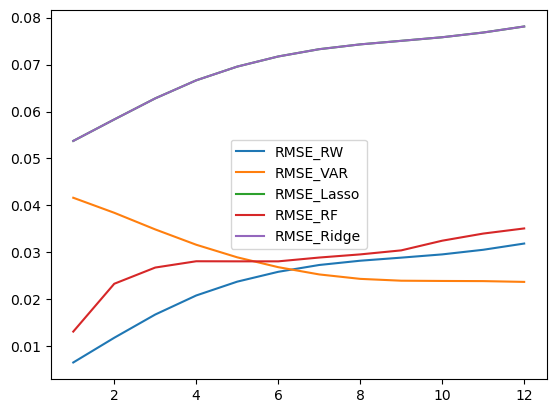

In [36]:
pd.concat([RMSE_rw, RMSE_var, RMSE_lasso, RMSE_rf, RMSE_ridge], axis=1).plot()

### 3.2.4 Random Forest Regression (validation test) -> best results so far -> try tomorrow with other models

This version fits the model with the hyperparameters found in the gridsearch, then predicts with the fitted model. Same results as 3.2.3 

In [37]:
# # Divide data in training and testing sets
# train_data = df_lags[df_lags.index <= '2021-12-31']
# test_data = df_lags[(df_lags.index >= '2022-01-01') & (df_lags.index <= '2022-12-31')]

# # Define target and predictors
# target = 'CPI'
# X_train = train_data.drop(columns=[target])
# y_train = train_data[target]

# X_test = test_data.drop(columns=[target])
# y_test = test_data[target]


In [38]:
# target = "CPI"
# Y = pd.DataFrame(df_lags[target])
# X = df_lags.drop(columns=[target])

# train_set = df_lags[df_lags.index < '2022-01-01']
# test_set  = df_lags[df_lags.index >= '2022-01-01']

# y_train = train_set[target]
# y_test  = test_set[target]
# X_train = train_set.loc[:, train_set.columns != target]
# X_test  = test_set.loc[:, test_set.columns != target]

# # Implementing the temporal cross-validation
# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# # We implement the model
# from sklearn.ensemble import RandomForestRegressor
# random_forest = RandomForestRegressor( random_state = 2024, n_jobs = -1 )
# model = random_forest


In [39]:
# from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
# from sklearn.ensemble import RandomForestRegressor

# # Configuración de GridSearchCV
# tscv = TimeSeriesSplit(n_splits=5)
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_features': ['auto', 'sqrt'],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }

# model = RandomForestRegressor(random_state=2024)
# grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

# # Mejores hiperparámetros
# best_params = grid_search.best_params_
# print("Best parameters:", best_params)


In [40]:
# # Entrenar con los mejores parámetros
# best_model = RandomForestRegressor(**best_params, random_state=2024)
# best_model.fit(X_train, y_train)

# # Evaluación en el conjunto de validación
# from sklearn.metrics import mean_squared_error

# validation_predictions = best_model.predict(X_validation)
# validation_mse = mean_squared_error(y_test, validation_predictions)
# print("Validation MSE:", validation_mse)



In [41]:
# preds = pd.DataFrame(validation_predictions, index = y_validation.index)
# y_validation = pd.DataFrame(y_validation)

In [42]:
# ### BEST RESULTS TRY TOMORROW
# results = pd.concat([preds, y_validation],axis=1)
# results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
# results

In [43]:
# RMSE_rf, MAPE_rf = get_metrics(results, 'RF')

In [44]:
# pd.concat([RMSE_rw, RMSE_lasso, RMSE_ridge, RMSE_var, RMSE_rf], axis=1).plot()

### 3.2.3 Random Forest Regression (Random Forest) v2

In [45]:
# def lags(data, lag, raw=False):
   
#    if raw == True:
#        lag_range = range(1, lag)
#    else:
#        lag_range = range(0, lag)

#    # Shift the data 
#    data = pd.concat([data.shift(i+1) for i in lag_range],axis=1)

#    # Name columns
#    data.columns = ['lag_%d' %i for i in lag_range]
    
#    # Drop rows with NaN values 
#    return data.dropna()

# def _rfTune(train, y_key, h, model_config):

#     model = RandomForestRegressor(n_jobs = 30)
#     cv_strategy = TimeSeriesSplit(n_splits=5, gap=h-1, test_size=1)
#     model = GridSearchCV(estimator=model, param_grid=model_config["grid"], cv=cv_strategy, verbose=0, scoring="neg_mean_squared_error", refit=False, n_jobs = 30)
#     model.fit(train.drop(y_key, axis=1), train[y_key])
#     best_model_mean = model.best_params_  # sklearn default, same as params[argmax(mean(cv_scores))]

#     return best_model_mean

# def _rfPred(train, test, y_key, best_model_mean, model_config):
    
#     rs = np.random.RandomState(seed = 2024)
#     mean_model = RandomForestRegressor(n_jobs = 30)
#     mean_model.fit(train.drop(y_key, axis=1), train[y_key])
#     y_hat_mean = pd.Series(mean_model.predict(test.drop(y_key, axis=1)), index=test.index).rename("rf_tune_mean_y_hat")
#     preds = y_hat_mean

#     return preds, mean_model

# def _diff(df):
#     # This function first difference any inflation series with an observation more extreme than 50%
#     Outputdf = pd.DataFrame(np.nan, index = df.index, columns = df.columns )
    
#     for columns in df:
#         if (0.5 < df[columns]).any() == True:
#             diffed = df[columns].diff()
#         else:
#             diffed = df[columns]

#         Outputdf[columns] = diffed

#     # We remove NaN caused by first differencing
#     Outputdf = Outputdf.fillna(method='backfill') 
    
#     return Outputdf

In [46]:
#!pip install shap

#import shap

In [47]:
# max_lags = 4 # Lags for the autoregressive part
# win1 = 12*15 # Starts predicting approximately in the year 2018
# horizon_vector = [1, 3, 6, 12]

# # Model config for RF
# model_config_rf = {"grid": {"max_features": [None, 2/3, 1/3, "sqrt", "log2"],
#                             "n_estimators": np.arange(5, 16)
#                             }
#                    }

In [48]:
# ### PROBAR ESTE CÓDIGO EN QLAB
# # lA IDEA ES QUE SOLO SE PREDIGA LA PRIMERA COLUMNA, YA NO TODAS

# for h in horizon_vector:
    
#     print(f'horizon: {h}')
    
#     win2 = win1+h
    
#     Inflation_data = df.shift(periods = h).dropna()
    
#     data_cpi = df.iloc[1:,0]

#     Ret = data_cpi.rolling(h).mean().dropna() 
    
#     Ret = Ret.to_frame("CPI")
    
#     # Define placeholders for forecasting models
#     fcast_RF = np.empty((len(Ret), Inflation_data.shape[1]))*np.nan

#     # Define placeholders for forecast errors
#     e_RF = np.empty((len(Ret), Inflation_data.shape[1]))*np.nan
    
#     for t in range(win2, len(Ret)+1):
        
#         print(f'window : {t}')
            
#         tempt_global = Inflation_data[t-win2:t]         
#         tempt_global = tempt_global.drop(data_cpi.name, axis = 1)   

# #     # Slice the train data and test data
# #             train_set = df[df.index < '2019-01-01']
# #             test_set  = df[df.index >= '2019-01-01'] 

# #             y_train = train_set[target]
# #             y_test  = test_set[target]
# #     X_train = train_set.loc[:, train_set.columns != target]
# #     X_test  = test_set.loc[:, test_set.columns != target]
#         train_Ret = Ret[t-win2:t-h]
#         train_Inflation = tempt_global[:-h]
#         train_AR_data = data_cpi[t-win2:t-h]

#         # Slice the test data
#         test_Ret = Ret.iloc[t-1,:].to_frame().T
#         test_Inflation = tempt_global.iloc[-1].to_frame().T
#         test_AR_data = data_cpi[t-win2:t]

#         # Compute lags
#         Lags_train_y = lags(train_AR_data, max_lags, raw=False) # Fix the function at some point
#         Lags_test_y = lags(test_AR_data, max_lags, raw=False) # Fix the function at some point
#         Lags_train_y = Lags_train_y.set_index(train_AR_data.index[max_lags:])
#         Lags_test_y = Lags_test_y.iloc[-1:]
#         Lags_test_y = Lags_test_y.set_index(test_AR_data.index[-h:])

#         # Concat into train and test data sets
#         train = pd.concat([train_Inflation, train_Ret, train_AR_data, Lags_train_y], axis=1).dropna()
#         test = pd.concat([test_Inflation, test_Ret, test_AR_data, Lags_test_y], axis=1).dropna()

#         # Perform RandomF forecast
#         if t == win2:
#             FittedRF = _rfTune(train, 'CPI', h, model_config_rf)

#         elif pd.to_datetime(test_Ret.index[0]).month == 12:
#             FittedRF = _rfTune(train, 'CPI', h, model_config_rf)
            
#         fcast_RF[t-1, i], RF_model = _rfPred(train, test, 'CPI', FittedRF, model_config_rf)
    

In [49]:
# for h in horizon_vector:
    
#     win2 = win1+h
    
#     Inflation_data = df.shift(periods = h).dropna()

#     for i in range(0, df.shape[1]):
        
#         print(i)
            
#         data_temp = df.iloc[1:,i]
#         Ret = data_temp.rolling(h).mean().dropna()
#         Ret = Ret.to_frame("Returns")
        
#         if i == 0:
#             # Define placeholders for forecasting models
#             fcast_RF = np.empty((len(Ret), Inflation_data.shape[1]))*np.nan
            
#             # Define placeholders for forecast errors
#             e_RF = np.empty((len(Ret), Inflation_data.shape[1]))*np.nan
            
            
            

In [50]:
# ## lAST TRY

# for h in horizon_vector:
    
#     print(f'Calculating for horizon: {h}')
    
#     # We define our window
#     win2 = win1+h
    
#     Inflation_data = df.shift(periods = h).dropna()

In [51]:
# for h in horizon_vector:
    
#     win2 = win1+h
    
#     Inflation_data = df.shift(periods = h).dropna()

#     for i in range(0, df.shape[1]):
        
#         print(i)
            
#         data_temp = df.iloc[1:,i]
#         Ret = data_temp.rolling(h).mean().dropna()
#         Ret = Ret.to_frame("Returns")
        
#         if i == 0:
#             # Define placeholders for forecasting models
#             fcast_RF = np.empty((len(Ret), Inflation_data.shape[1]))*np.nan
            
#             # Define placeholders for forecast errors
#             e_RF = np.empty((len(Ret), Inflation_data.shape[1]))*np.nan
            
#         for t in range(win2, len(Ret)+1):
            
# #             # Diff data if necessary
#             tempt_global = Inflation_data[t-win2:t]
# #             tempt_region = Region[t-win2:t]
# #             diffed_region = _diff(tempt_region)
            
# #             # Compute factors
# #             MeanGlobal = pd.DataFrame(np.mean(diffed_global, axis=1), columns=["MeanGlobal"], index=diffed_global.index)
# #             MeanRegion = pd.DataFrame(np.mean(diffed_region, axis=1), columns=["MeanRegion"], index=diffed_region.index)
            
#             # Drop country we are currently forecasting
#             tempt_global = tempt_global.drop(data_temp.name, axis = 1)
            
#             # Slice the train data
#             train_Ret = Ret[t-win2:t-h]
#             train_Inflation = tempt_global[:-h]
#             train_AR_data = data_temp[t-win2:t-h]
            
#             # Slice the test data
#             test_Ret = Ret.iloc[t-1,:].to_frame().T
#             test_Inflation = tempt_global.iloc[-1].to_frame().T
#             test_AR_data = data_temp[t-win2:t]

#             # Compute lags
#             Lags_train_y = lags(train_AR_data, max_lags, raw=False) # Fix the function at some point
#             Lags_test_y = lags(test_AR_data, max_lags, raw=False) # Fix the function at some point
#             Lags_train_y = Lags_train_y.set_index(train_Ret.index[max_lags:])
#             Lags_test_y = Lags_test_y.iloc[-h:]
#             Lags_test_y = Lags_test_y.set_index(test_Ret.index)
            
#             # Concat into train and test data sets
#             train = pd.concat([train_Ret, train_Inflation, Lags_train_y], axis=1).dropna()
#             test = pd.concat([test_Ret, test_Inflation, Lags_test_y], axis=1).dropna()
            
#             # Perform RandomF forecast
#             if t == win2:
#                 FittedRF = _rfTune(train, 'Returns', h, model_config_rf)
                
#             elif pd.to_datetime(test_Ret.index[0]).month == 12:
#                 FittedRF = _rfTune(train, 'Returns', h, model_config_rf)
                
#             fcast_RF[t-1, i], RF_model = _rfPred(train, test, 'Returns', FittedRF, model_config_rf)
#             e_RF[t-1, i] = test['Returns'] - fcast_RF[t-1, i]            


## 3.3 Results
Here we concat all results into a single dataframe. We export the table to excel.


### 3.3.1 General results
Here we will create graphs and tables with the results of all models combined into a single datagrame.

In [52]:
RMSE_2022 = pd.concat([RMSE_rw, RMSE_var, RMSE_ridge, RMSE_lasso, RMSE_rf], axis=1)
MAPE_2022 = pd.concat([MAPE_rw, MAPE_var, MAPE_ridge, MAPE_lasso, MAPE_rf], axis=1)

In [53]:
RMSE_2022

,RMSE_RW,RMSE_VAR,RMSE_Ridge,RMSE_Lasso,RMSE_RF
1,0.006527,0.041628,0.053735,0.053735,0.013109
2,0.011793,0.038424,0.058313,0.058313,0.023300
3,0.016746,0.034879,0.062804,0.062804,0.026755
4,0.020805,0.031613,0.066650,0.066650,0.028095
5,0.023751,0.028933,0.069573,0.069573,0.028076
6,0.025846,0.026834,0.071731,0.071731,0.028075
7,0.027300,0.025287,0.073283,0.073283,0.028887
8,0.028210,0.024342,0.074307,0.074307,0.029556
9,0.028865,0.023951,0.075062,0.075062,0.030413
10,0.029558,0.023897,0.075828,0.075828,0.032476


<Axes: >

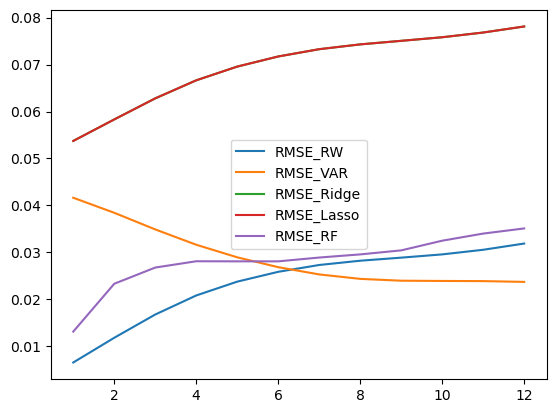

In [54]:
colors = {'RMSE_RW': 'tab:orange', 'RMSE_VAR': 'tab:blue', 'RMSE_Ridge': 'tab:green', 'RMSE_Lasso': 'tab:red', 'RMSE_RF': 'tab:purple'}

RMSE_2022.plot(label=colors)

In [55]:
RMSE_2022_results = RMSE_2022.div(RMSE_rw['RMSE_RW'], axis=0)
RMSE_2022_results = RMSE_2022_results.drop(columns=['RMSE_RW'])
RMSE_2022_results_highlight = RMSE_2022_results.style.apply(highlight_min, axis=1)
RMSE_2022_results_highlight

,RMSE_VAR,RMSE_Ridge,RMSE_Lasso,RMSE_RF
1,6.378055,8.233112,8.233112,2.008481
2,3.258035,4.944513,4.944513,1.975669
3,2.082898,3.750476,3.750476,1.597731
4,1.519474,3.203520,3.203520,1.350398
5,1.218175,2.929307,2.929307,1.182124
6,1.038224,2.775316,2.775316,1.086233
7,0.926275,2.684355,2.684355,1.058128
8,0.862859,2.634025,2.634025,1.047711
9,0.829756,2.600481,2.600481,1.053635
10,0.808471,2.565398,2.565398,1.098738


In [56]:
MAPE_2022_results = MAPE_2022.div(MAPE_rw['MAPE_RW'], axis=0)
MAPE_2022_results = MAPE_2022_results.drop(columns=['MAPE_RW'])
MAPE_2022_results_highlight = MAPE_2022_results.style.apply(highlight_min, axis=1)
MAPE_2022_results_highlight

,MAPE_VAR,MAPE_Ridge,MAPE_Lasso,MAPE_RF
1,6.378055,8.233112,8.233112,2.008481
2,3.457828,5.273827,5.273827,1.980859
3,2.200442,4.049107,4.049107,1.655046
4,1.551905,3.445249,3.445249,1.412191
5,1.191457,3.123394,3.123394,1.233396
6,0.977392,2.934590,2.934590,1.128429
7,0.852393,2.818022,2.818022,1.094202
8,0.791237,2.748266,2.748266,1.078613
9,0.766069,2.700059,2.700059,1.079694
10,0.753095,2.653992,2.653992,1.113138


In [57]:
tableH22 = RMSE_rw.join(RMSE_2022_results)
tableH22 = tableH22.rename(columns = {'RMSE_RW': 'Benchmark', 'RMSE_ARIMA': 'ARIMA', 'RMSE_VAR': 'VAR', 'RMSE_Ridge': 'Ridge', 
                            'RMSE_Lasso': 'Lasso', 'RMSE_RF':'RF'})
tableH22.index.name = 'horizon'
tableH22.to_excel("../../../output/3_Regression/h19_test/h19table_rmse.xlsx")

In [58]:
tableH22 = MAPE_rw.join(MAPE_2022_results)
tableH22 = tableH22.rename(columns = {'MAPE_RW': 'Benchmark', 'MAPE_ARIMA': 'ARIMA', 'MAPE_VAR': 'VAR', 'MAPE_Ridge': 'Ridge', 
                            'MAPE_Lasso': 'Lasso', 'MAPE_RF':'RF'})
tableH22.index.name = 'horizon'
tableH22.to_excel("../../../output/3_Regression/h19_test/h19table_mape.xlsx")

In [59]:
colors = {
    'RMSE_VAR': 'blue',   
    'RMSE_Ridge': 'green', 
    'RMSE_Lasso': 'red',  
    'RMSE_RF': 'purple'   
}

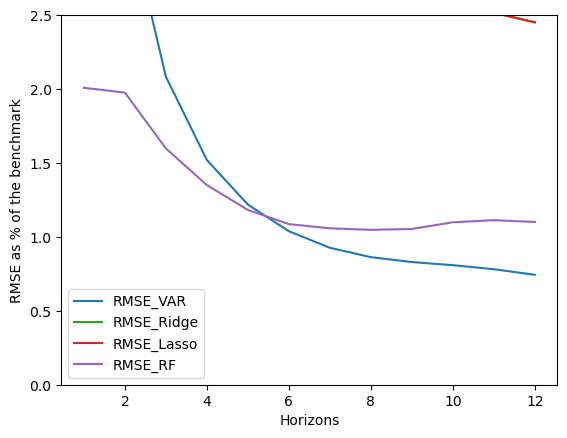

<Figure size 640x480 with 0 Axes>

In [60]:
colors = {'RMSE_VAR': 'tab:blue', 'RMSE_Ridge': 'tab:green', 'RMSE_Lasso': 'tab:red', 'RMSE_RF': 'tab:purple'}

graph_models(RMSE_2022_results, lim=2.5, colors=colors)

plt.savefig("../../../output/3_Regression/h19_test/h19_rmse.png", bbox_inches='tight', dpi=300)

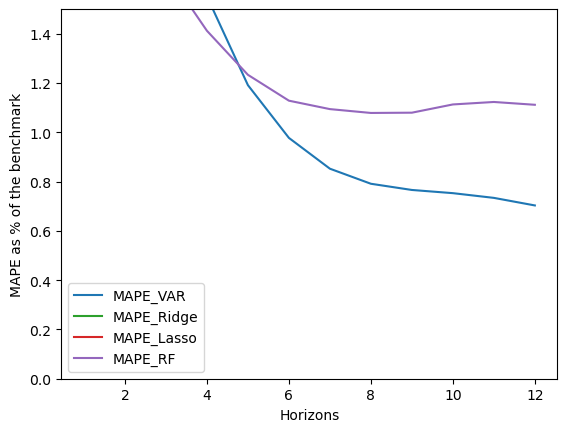

<Figure size 640x480 with 0 Axes>

In [61]:
colors = {'MAPE_VAR': 'tab:blue', 'MAPE_Ridge': 'tab:green', 'MAPE_Lasso': 'tab:red', 'MAPE_RF': 'tab:purple'}

graph_models(MAPE_2022_results, metric = "MAPE", lim=1.5, colors=colors)

plt.savefig("../../../output/3_Regression/h19_test/h19_mape.png", bbox_inches='tight', dpi=300)

### 3.3.2 Coefficients by model

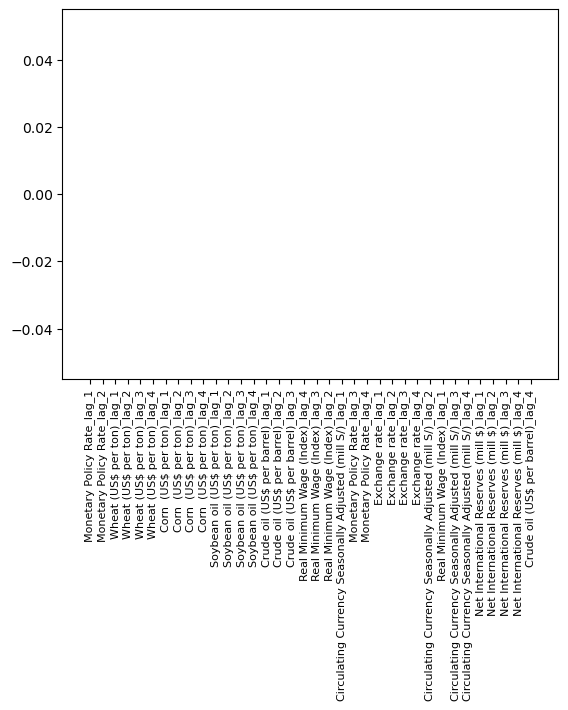

<Figure size 640x480 with 0 Axes>

In [62]:
graph_coefficients(vars_df_ridge, value = "Coefficient")

plt.savefig("../../../output/3_Regression/h19_test/h19_coef_ridge.png", bbox_inches='tight', dpi=300)

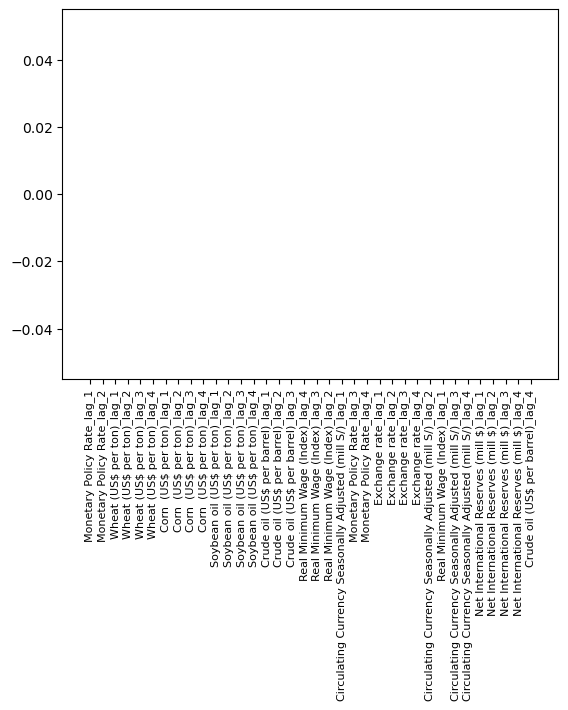

<Figure size 640x480 with 0 Axes>

In [63]:
graph_coefficients(vars_df_lasso, value = "Coefficient")

plt.savefig("../../../output/3_Regression/h19_test/h19_coef_lasso.png", bbox_inches='tight', dpi=300)

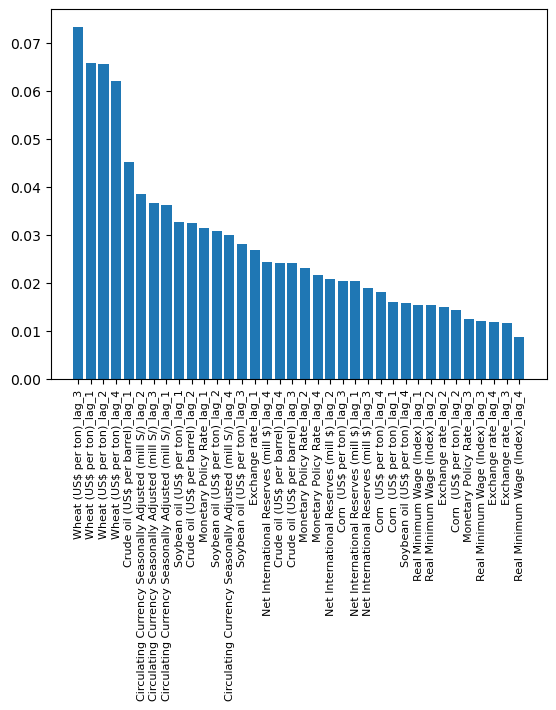

<Figure size 640x480 with 0 Axes>

In [64]:
graph_coefficients(vars_df_rf, value = "Importance Score")

plt.savefig("../../../output/3_Regression/h19_test/h19_coef_rf.png", bbox_inches='tight', dpi=300)

### 3.3.3 Prediction plots
We are going to plot our predictions in a single plot to compare visually how different models performed

Text(0, 0.5, 'CPI')

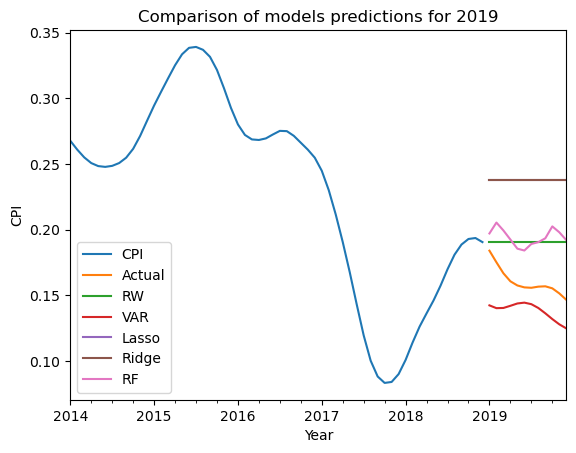

In [65]:
y_train['2014':].plot(label=None)
df['CPI']['2019-01-01':].plot(label='Actual')
results_rw['Predicted'].plot(label='RW')
results_var['Predicted'].plot(label='VAR')
results_lasso['Predicted'].plot(label='Lasso')
results_ridge['Predicted'].plot(label='Ridge')
results_rf['Predicted'].plot(label='RF')

plt.legend()

plt.title('Comparison of models predictions for 2019')
plt.xlabel('Year')
plt.ylabel('CPI')